In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 18
%matplotlib inline

In [2]:
!pip install shap --upgrade --user

In [2]:
import shap
shap.initjs()

# SHAPによる非線形のFit
## 基礎編：支出によるShareとSHAPのShareの差を確認し、投資金額が妥当化を判断する
## 発展編（次回）：AdstockやProphetの時系列成分を入れて算定

In [3]:
data = pd.read_csv("data_raw_Robyn.csv")

In [4]:
data.head()

,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,167687.6,0,95463.666667,7.290385e+07,0.000000,0,8125009,228213.987444,na,19401.653846
1,2015-11-30,2.584277e+06,214600.9,0,0.000000,1.658110e+07,29511.715457,31000,7901549,34258.573511,na,14791.000000
2,2015-12-07,2.547387e+06,0.0,248022,3404.000000,4.995477e+07,36132.358958,28400,8300197,127691.261335,na,14544.000000
3,2015-12-14,2.875220e+06,625877.3,0,132600.000000,3.164930e+07,36804.210958,31900,8122883,84014.720306,na,2800.000000
4,2015-12-21,2.215953e+06,0.0,520005,0.000000,8.802269e+06,28401.744069,27100,7105985,20687.478156,na,15478.000000


In [5]:
data["events"] = np.where(data["events"]=="na", 0, 1)

In [6]:
target = "revenue"
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"]
organic_channels = ["newsletter"]
features = ["competitor_sales_B", "events"] + media_channels + organic_channels

In [7]:
n_estimators = 5
min_samples_leaf = 1
min_samples_split = 2
max_depth = 4
ccp_alpha = 0.3
bootstrap = True

scores = []

tscv = TimeSeriesSplit(n_splits=3, test_size = 10)

for train_index, test_index in tscv.split(data):
    x_train = data.iloc[train_index][features]
    y_train =  data[target].values[train_index]

    x_test = data.iloc[test_index][features]
    y_test = data[target].values[test_index]

    #apply Random Forest
    params = {"n_estimators": n_estimators, 
               "min_samples_leaf":min_samples_leaf, 
               "min_samples_split" : min_samples_split,
               "max_depth" : max_depth, 
               "ccp_alpha" : ccp_alpha, 
               "bootstrap" : bootstrap
             }

    rf = RandomForestRegressor(random_state=0, **params)
    print(x_train.isna().sum())
    rf.fit(x_train, y_train)
    prediction = rf.predict(x_test)

    rmse = mean_squared_error(y_true = y_test, y_pred = prediction, squared = False)
    scores.append(rmse)

competitor_sales_B    0
events                0
tv_S                  0
ooh_S                 0
print_S               0
facebook_S            0
search_S              0
newsletter            0
dtype: int64
competitor_sales_B    0
events                0
tv_S                  0
ooh_S                 0
print_S               0
facebook_S            0
search_S              0
newsletter            0
dtype: int64
competitor_sales_B    0
events                0
tv_S                  0
ooh_S                 0
print_S               0
facebook_S            0
search_S              0
newsletter            0
dtype: int64


In [8]:
rf.feature_importances_

array([9.29992916e-01, 1.29638661e-02, 2.51032571e-02, 8.20799469e-04,
       0.00000000e+00, 2.19597468e-02, 1.12484914e-04, 9.04692962e-03])

In [9]:
features

['competitor_sales_B',
 'events',
 'tv_S',
 'ooh_S',
 'print_S',
 'facebook_S',
 'search_S',
 'newsletter']

In [10]:
prediction = rf.predict(data[features])

In [11]:
scores

[286452.92525796464, 444040.92645618663, 107671.8448342083]

In [12]:
data["revenue"].mean()

1822142.7724358966

In [18]:
for score in scores:
    print(score/data["revenue"].mean())

0.15720663034270665
0.24369162130066188
0.05909078391824877


In [19]:
def nrmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2)) / (np.max(y_true) - np.min(y_true))

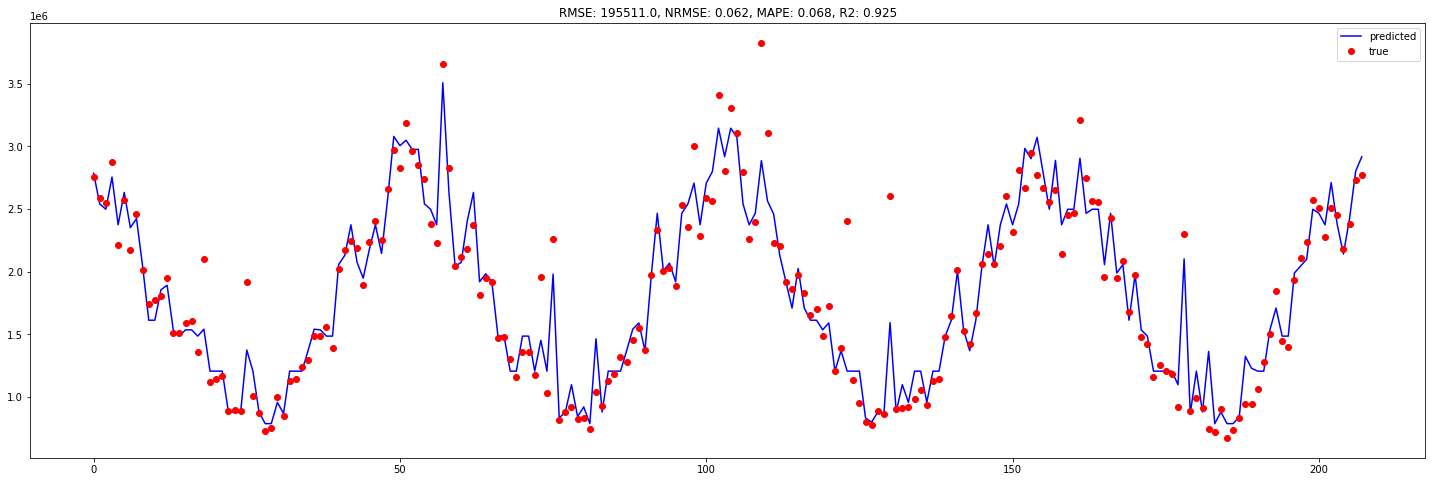

In [20]:
rmse_metric = mean_squared_error(y_true = data["revenue"], y_pred = prediction, squared=False)
mape_metric = mean_absolute_percentage_error(y_true = data["revenue"], y_pred = prediction)
nrmse_metric = nrmse(data["revenue"],  prediction)
r2_metric = r2_score(y_true = data["revenue"], y_pred = prediction)

fig, ax = plt.subplots(figsize = (25, 8))
_ = ax.plot(prediction, color = "blue", label = "predicted")
_ = ax.plot(data["revenue"], 'ro', label = "true")
_ = plt.title(f"RMSE: {np.round(rmse_metric)}, NRMSE: {np.round(nrmse_metric, 3)}, MAPE: {np.round(mape_metric, 3)}, R2: {np.round(r2_metric,3)}")
_ = ax.legend()

In [21]:
explainer = shap.TreeExplainer(rf)
# SHAP valuesを取得
shap_values_train = explainer.shap_values(data[features])

# create a dataframe of the shap values for the training set and the test set
df_shap_values = pd.DataFrame(shap_values_train, columns=features)

In [25]:
df_shap_values

,competitor_sales_B,events,tv_S,ooh_S,print_S,facebook_S,search_S,newsletter
0,8.739340e+05,-3031.919735,33424.328948,-1051.710321,0.0,92620.793706,-1474.444024,-17761.978637
1,7.395428e+05,-3031.919735,67768.757015,-1051.710321,0.0,-55781.521443,294.888805,-16343.351473
2,7.765987e+05,-3182.428152,-42918.320776,4042.484680,0.0,-29205.827323,90.735017,-16343.351473
3,8.020430e+05,-3031.919735,115555.643246,-1051.710321,0.0,-68968.517971,294.888805,101370.137304
4,6.458310e+05,-3182.428152,-40397.252337,4042.484680,0.0,-40012.795000,90.735017,-1326.609588
...,...,...,...,...,...,...,...,...
203,6.548326e+05,-3182.428152,-40410.796877,-1051.710321,0.0,-42488.043555,90.735017,-2745.236753
204,2.731684e+05,-3031.919735,34181.478944,-1051.710321,0.0,14016.052182,3621.839422,10810.533930
205,6.738449e+05,-3031.919735,-11684.554198,-1051.710321,0.0,-42488.043555,90.735017,-1326.609588
206,1.047818e+06,-3031.919735,-7640.603682,-1051.710321,0.0,-31972.347751,90.735017,-12108.990333


competitor_sales_B    0.863873
events                0.013476
tv_S                  0.066139
ooh_S                 0.004834
print_S               0.000000
facebook_S            0.037328
search_S              0.000769
newsletter            0.013582
dtype: float64


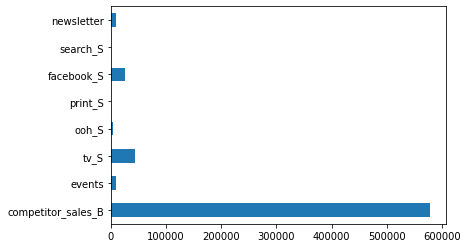

In [76]:
np.abs(df_shap_values).mean().plot.barh()
print(np.abs(df_shap_values).mean()/ np.abs(df_shap_values).mean().sum())

                           0
competitor_sales_B  0.929993
events              0.012964
tv_S                0.025103
ooh_S               0.000821
print_S             0.000000
facebook_S          0.021960
search_S            0.000112
newsletter          0.009047


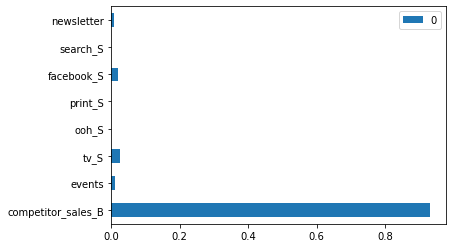

In [73]:
importance = pd.DataFrame(rf.feature_importances_)
importance.index = features
importance.plot.barh()
print(importance)

Text(0, 0.5, 'revenue')

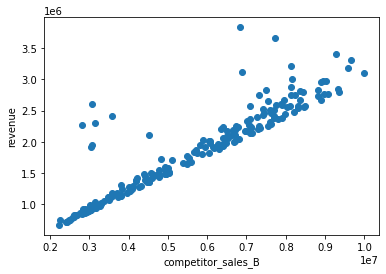

In [64]:
plt.scatter(data["competitor_sales_B"], data["revenue"])
plt.xlabel("competitor_sales_B")
plt.ylabel("revenue")

In [55]:
corlist = []
for feature in features:
    print(feature)
    #print(np.corrcoef(df_shap_values[feature], data.reset_index().drop("index", axis=1)[feature])[1][0])
    cornum = np.corrcoef(df_shap_values[feature], data.reset_index().drop("index", axis=1)[feature])[1][0]
    print(cornum)
    corlist.append( np.where(cornum >0, "red", "blue"))
    print("")

competitor_sales_B
0.9822159330676173

events
0.9551326224346581

tv_S
0.7060825837339891

ooh_S
0.5032098581915408

print_S
nan

facebook_S
0.5091920737870808

search_S
0.2541848367414739

newsletter
-0.36855505746918976



invalid value encountered in true_divide
invalid value encountered in true_divide


In [58]:
pd.DataFrame(corlist)

,0
0,red
1,red
2,red
3,red
4,blue
5,red
6,red
7,blue


<AxesSubplot:>

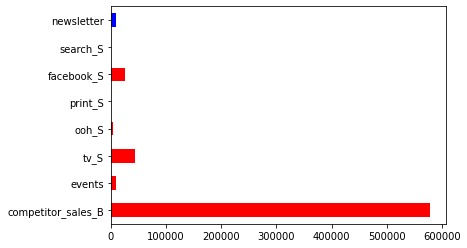

In [60]:
np.abs(df_shap_values).mean().plot.barh(color=pd.DataFrame(corlist)[0])

Text(0, 0.5, 'revenue')

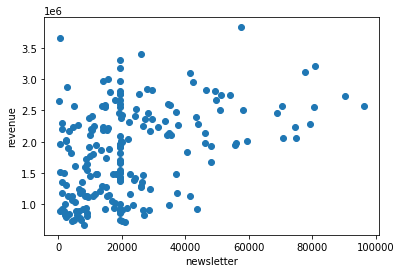

In [65]:
plt.scatter(data["newsletter"], data["revenue"])
plt.xlabel("newsletter")
plt.ylabel("revenue")

In [61]:
def shap_feature_importance(shap_values, data,features ,figsize = (20, 10)):
    
    feature_list = data.columns
    
    if isinstance(shap_values, pd.DataFrame) == False:
        shap_v = pd.DataFrame(shap_values)
        shap_v.columns = feature_list
    else:
        shap_v = shap_values
    
        
    df_v = data.copy().reset_index().drop('index',axis=1)
    
    # 元データとSHAPの相関
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # データフレームの作成（相関とカラーサインの作成）
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # 可視化
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=figsize,legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")

invalid value encountered in true_divide
invalid value encountered in true_divide


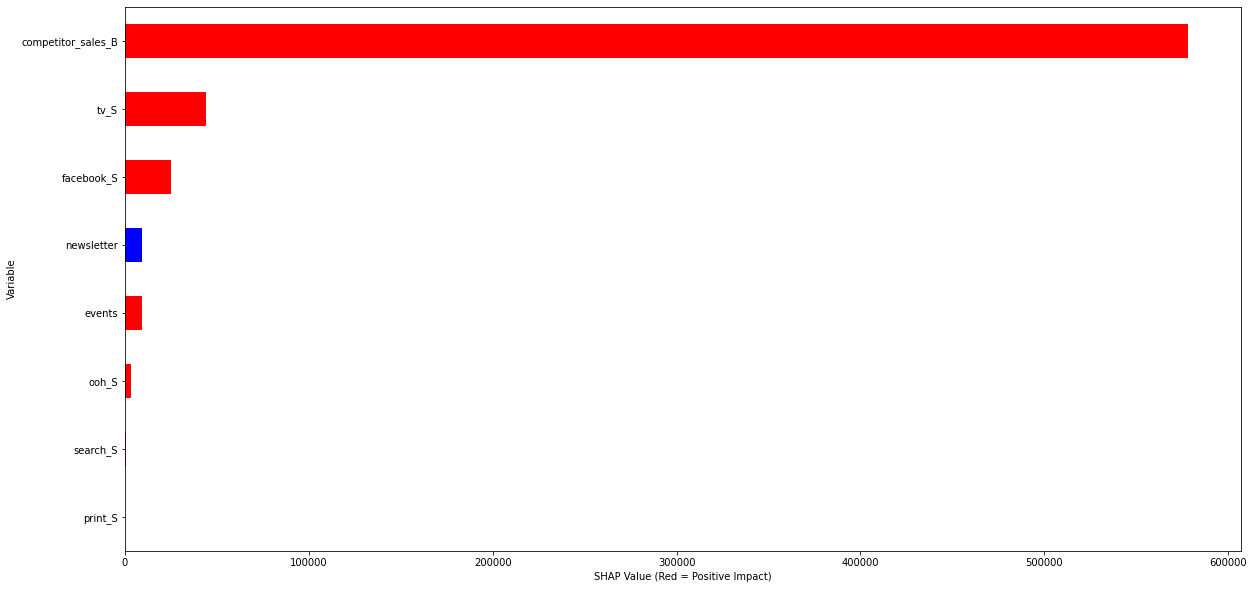

In [23]:
shap_feature_importance(df_shap_values, data[features], features)

# 支出の割合と影響度の算定

In [22]:
responses = pd.DataFrame(df_shap_values[media_channels].abs().sum(axis = 0), columns = ["effect_share"])
response_percentages = responses / responses.sum()
response_percentages

spends_percentages = pd.DataFrame(data[media_channels].sum(axis = 0) / data[media_channels].sum(axis = 0).sum(), columns = ["spend_share"])
spends_percentages

spend_effect_share = pd.merge(response_percentages, spends_percentages, left_index = True, right_index = True)
spend_effect_share = spend_effect_share.reset_index().rename(columns = {"index": "media"})

In [23]:
spend_effect_share

,media,effect_share,spend_share
0,tv_S,0.617131,0.338318
1,ooh_S,0.018937,0.246256
2,print_S,0.000000,0.084983
3,facebook_S,0.356545,0.195616
4,search_S,0.007386,0.134827


In [25]:
spend_effect_share.melt(id_vars=["media"])

,media,variable,value
0,tv_S,effect_share,0.617131
1,ooh_S,effect_share,0.018937
2,print_S,effect_share,0.000000
3,facebook_S,effect_share,0.356545
4,search_S,effect_share,0.007386
5,tv_S,spend_share,0.338318
6,ooh_S,spend_share,0.246256
7,print_S,spend_share,0.084983
8,facebook_S,spend_share,0.195616
9,search_S,spend_share,0.134827


In [26]:
spend_effect_share.melt(id_vars=["media"],value_vars = ["spend_share", "effect_share"])

,media,variable,value
0,tv_S,spend_share,0.338318
1,ooh_S,spend_share,0.246256
2,print_S,spend_share,0.084983
3,facebook_S,spend_share,0.195616
4,search_S,spend_share,0.134827
5,tv_S,effect_share,0.617131
6,ooh_S,effect_share,0.018937
7,print_S,effect_share,0.000000
8,facebook_S,effect_share,0.356545
9,search_S,effect_share,0.007386


# 可視化

In [78]:
spend_effect_share.head()

,media,effect_share,spend_share
0,tv_S,0.617131,0.338318
1,ooh_S,0.018937,0.246256
2,print_S,0.000000,0.084983
3,facebook_S,0.356545,0.195616
4,search_S,0.007386,0.134827


In [115]:
df_share = spend_effect_share.melt(id_vars=["media"],value_vars = ["spend_share", "effect_share"])

In [116]:
df_share.head()

,media,variable,value
0,tv_S,spend_share,0.338318
1,ooh_S,spend_share,0.246256
2,print_S,spend_share,0.084983
3,facebook_S,spend_share,0.195616
4,search_S,spend_share,0.134827


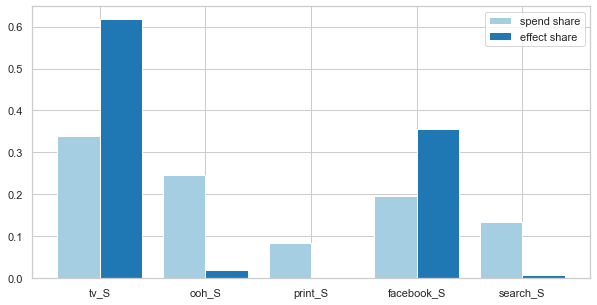

In [106]:

sns.set()
sns.set_style('whitegrid')
sns.set_palette('Paired')

x = np.array(spend_effect_share["media"].unique())
x_position = np.arange(len(x))


y_control = np.array(spend_effect_share["spend_share"])
y_stress = np.array(spend_effect_share["effect_share"])

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.bar(x_position, y_control,width=0.4,  label='spend share')
ax.bar(x_position + 0.4,  y_stress, width=0.4, label='effect share')
ax.legend()
ax.set_xticks(x_position + 0.2)
ax.set_xticklabels(x)
plt.show()


In [119]:
def plot_shap_vs_spend(df_shap_values, x_input_interval_nontransformed, x_input_interval_transformed, features, media_channels, figsize=(25, 10)):
    for channel in media_channels:
    
        #index = features.index(channel)

        mean_spend = x_input_interval_nontransformed.loc[x_input_interval_nontransformed[channel] > 0, channel].mean()

        fig, ax = plt.subplots(figsize=figsize)
        sns.regplot(x = x_input_interval_transformed[channel], y = df_shap_values[channel], label = channel,
                    scatter_kws={'alpha': 0.65}, line_kws={'color': 'C2', 'linewidth': 6},
                    lowess=True, ax=ax).set(title=f'{channel}: Spend vs Shapley')
        ax.axhline(0, linestyle = "--", color = "black", alpha = 0.5)
        ax.axvline(mean_spend, linestyle = "--", color = "red", alpha = 0.5, label=f"Average Spend: {int(mean_spend)}")
        ax.set_xlabel(f"{channel} spend")
        ax.set_ylabel(f'SHAP Value for {channel}')
        plt.legend()

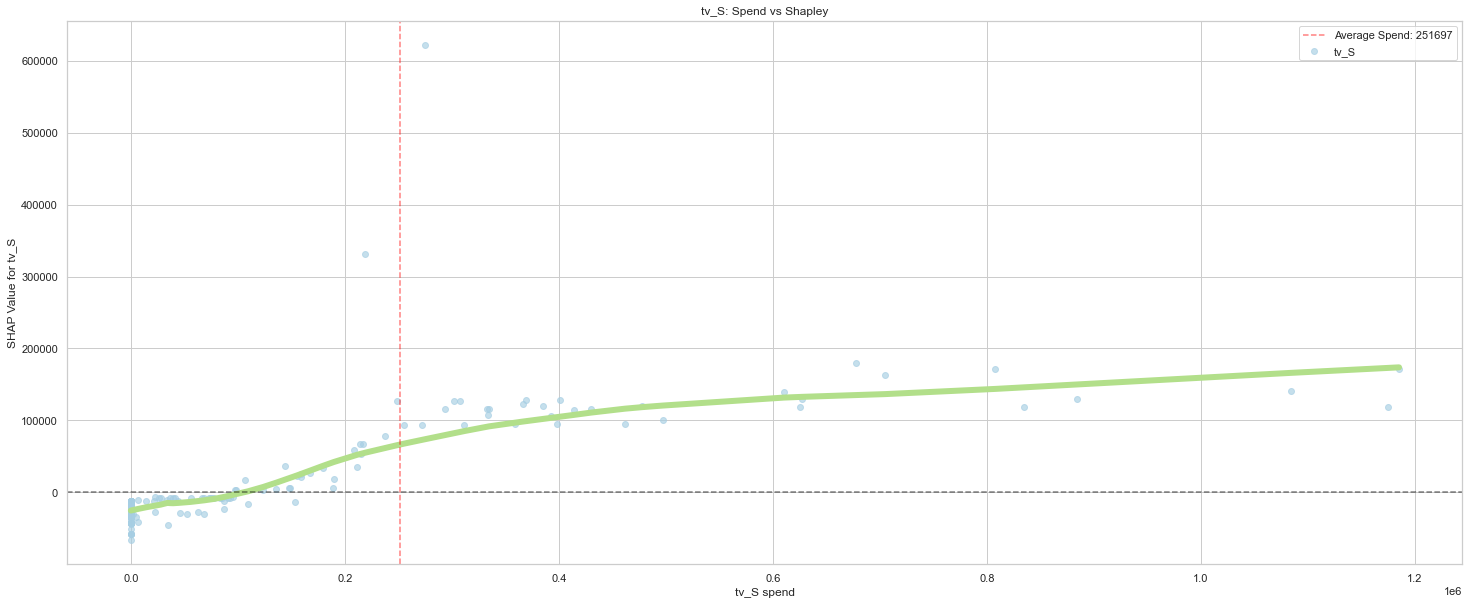

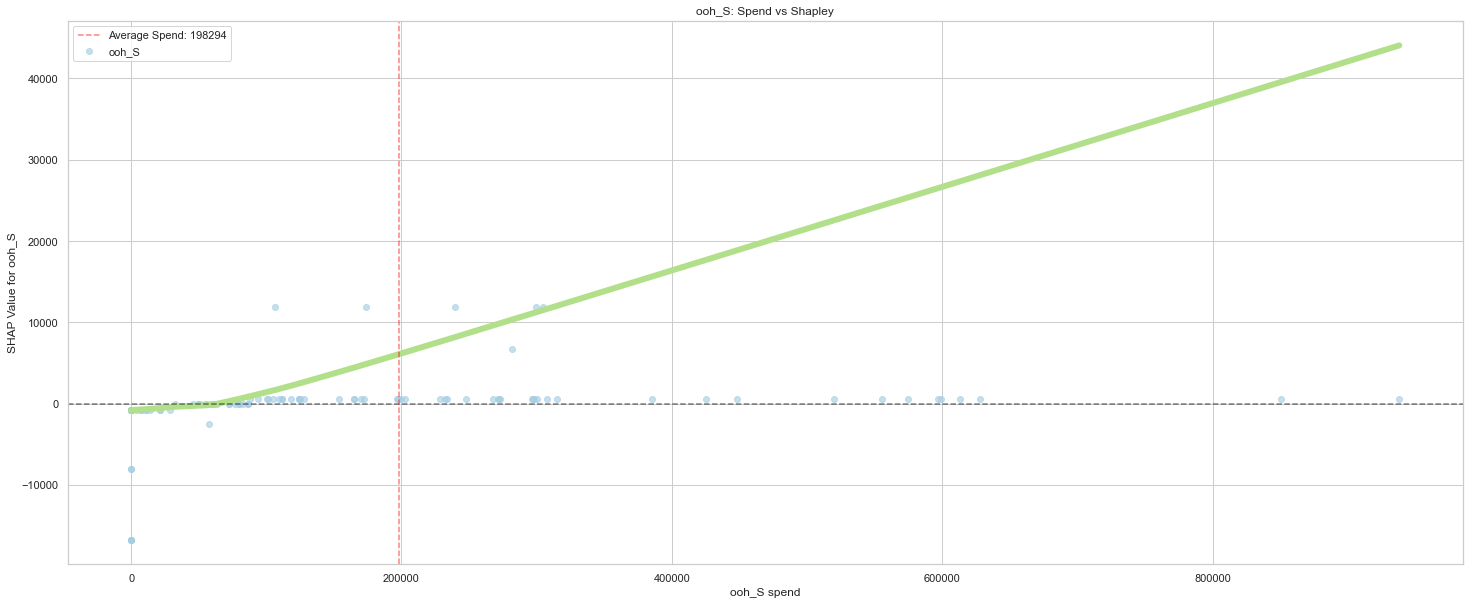

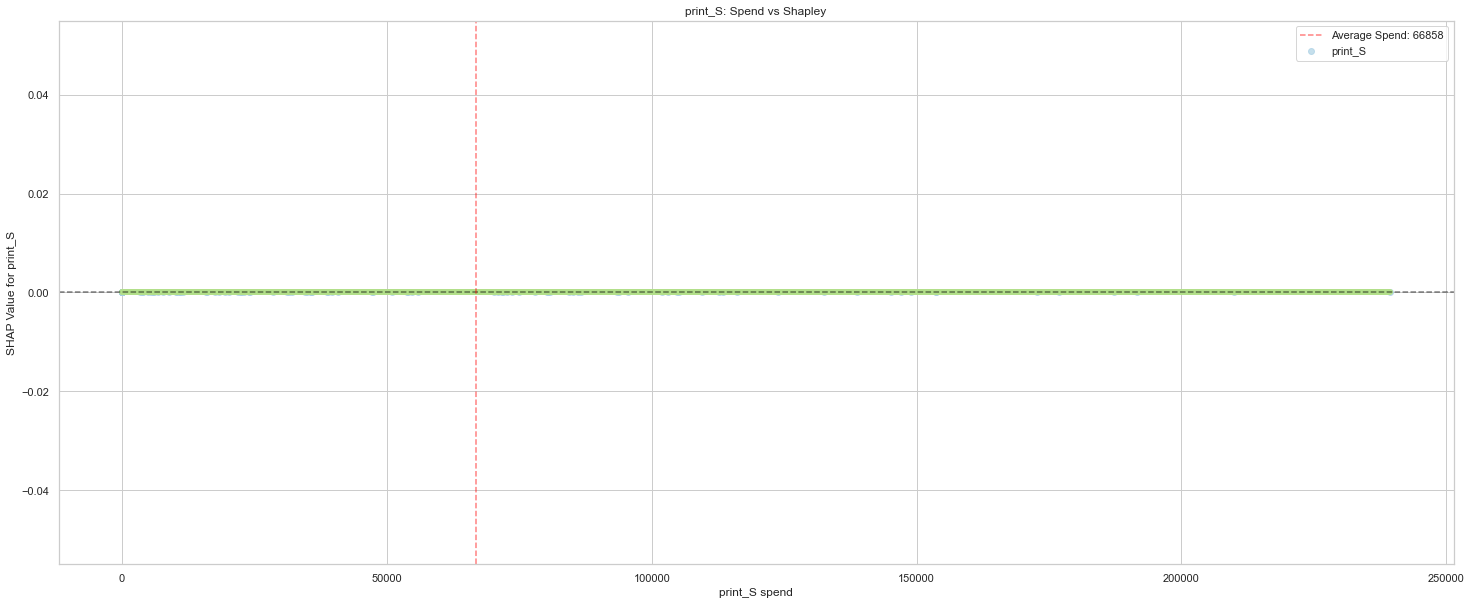

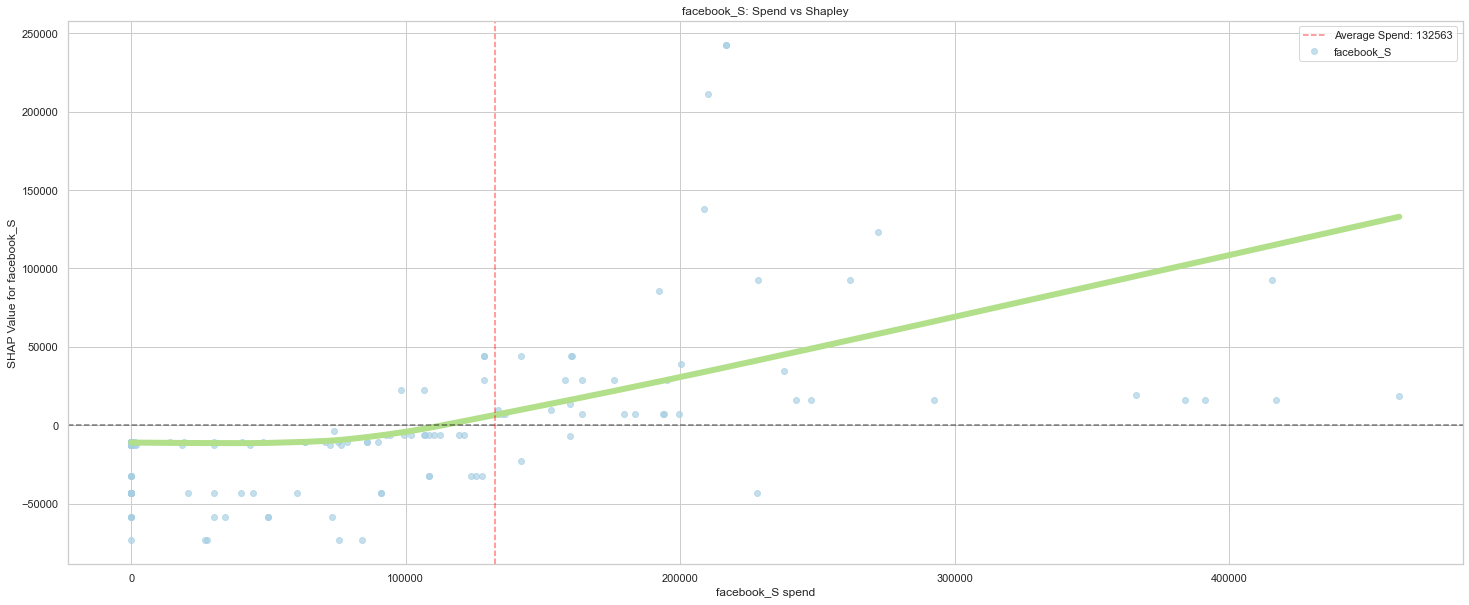

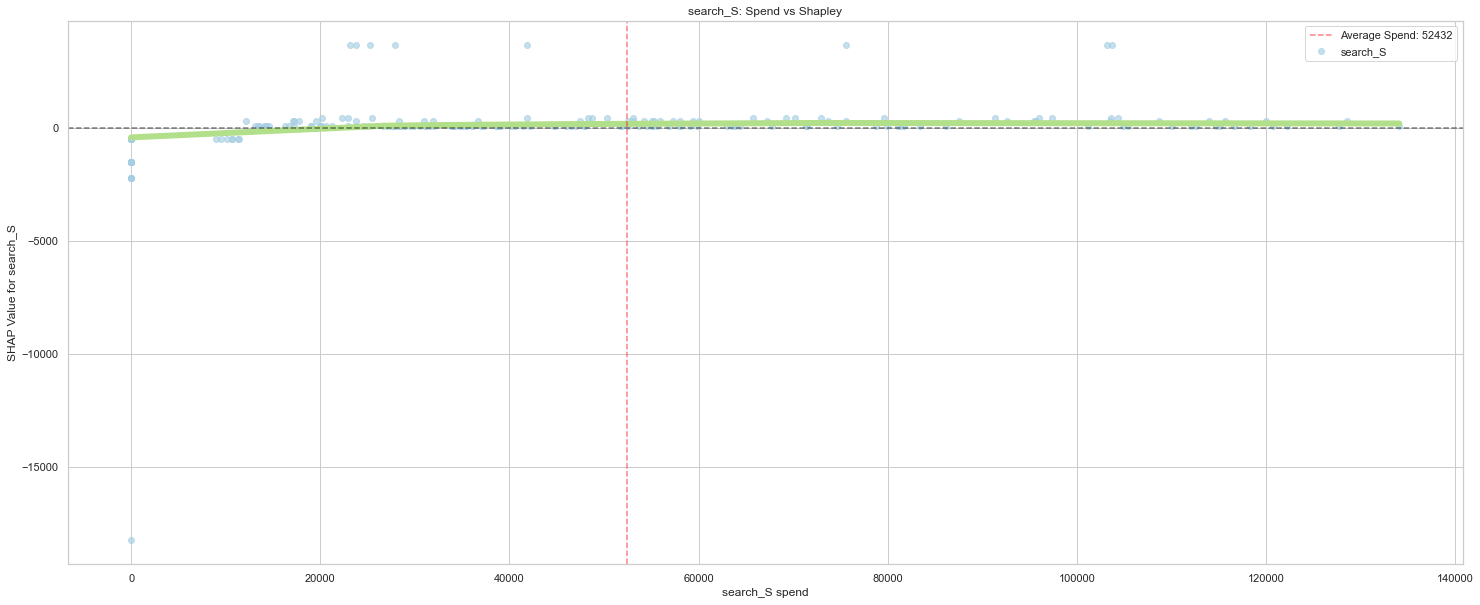

In [120]:
plot_shap_vs_spend(df_shap_values, data[features], data[features], features, media_channels)